**Report: Traffic Crash Injury Severity Prediction**

**1. Introduction**

This report documents the steps taken to analyze a traffic crash dataset and develop a model to predict the severity of injuries sustained in these crashes. The primary goal is to accurately predict the `MOST_SEVERE_INJURY` outcome, which is critical for understanding the factors contributing to injury severity and for potential applications in traffic safety and prevention.

**2. Data Loading and Initial Inspection**

* **Data Source:** The dataset, "traffic_crashes_2024.csv", was extracted from Traffic Crashes Data from Chicago Data Portal for the vehicles crashes in year 2024

* **Initial Columns:** A subset of relevant columns was selected for this analysis, including:

    * `POSTED_SPEED_LIMIT`: The speed limit at the location of the crash.
    * `TRAFFIC_CONTROL_DEVICE`: The type of traffic control device present (e.g., signals, signs).
    * `DEVICE_CONDITION`: The condition of the traffic control device.
    * `WEATHER_CONDITION`: The weather conditions at the time of the crash.
    * `LIGHTING_CONDITION`: The lighting conditions at the time of the crash (e.g., daylight, darkness).
    * `FIRST_CRASH_TYPE`: The manner in which the first harmful event occurred in a crash.
    * `TRAFFICWAY_TYPE`: The type of roadway (e.g., one-way street, divided highway).
    * `ALIGNMENT`: The horizontal and vertical alignment of the roadway.
    * `ROADWAY_SURFACE_COND`: The condition of the road surface (e.g., dry, wet).
    * `ROAD_DEFECT`: Any defects present on the roadway surface.
    * `NUM_UNITS`: The number of vehicles involved in the crash.
    * `CRASH_HOUR`: The hour of the day when the crash occurred.
    * `CRASH_DAY_OF_WEEK`: The day of the week when the crash occurred.
    * `CRASH_MONTH`: The month when the crash occurred.
    * `MOST_SEVERE_INJURY`: The most severe injury sustained by any person involved in the crash (target variable).
    * `DAMAGE`: A categorical variable indicating the extent of vehicle damage.

* **Rationale for Column Selection:**

    * These columns were chosen based on their potential relevance to predicting injury severity. They represent a range of factors that could contribute to the outcome of a crash, including:

        * Environmental conditions (`WEATHER_CONDITION`, `LIGHTING_CONDITION`, `ROADWAY_SURFACE_COND`).
        * Roadway characteristics (`POSTED_SPEED_LIMIT`, `TRAFFICWAY_TYPE`, `ALIGNMENT`, `ROAD_DEFECT`).
        * Traffic control (`TRAFFIC_CONTROL_DEVICE`, `DEVICE_CONDITION`).
        * Crash dynamics (`FIRST_CRASH_TYPE`, `NUM_UNITS`, `DAMAGE`).
        * Temporal factors (`CRASH_HOUR`, `CRASH_DAY_OF_WEEK`, `CRASH_MONTH`).
        * The target variable is `MOST_SEVERE_INJURY`.

In [146]:
import pandas as pd

# Load the data
df = pd.read_csv("/content/drive/MyDrive/traffic_crashes_2024.csv")


columns_to_use = [
    "POSTED_SPEED_LIMIT", "TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION",
    "WEATHER_CONDITION", "LIGHTING_CONDITION", "FIRST_CRASH_TYPE",
    "TRAFFICWAY_TYPE", "ALIGNMENT", "ROADWAY_SURFACE_COND", "ROAD_DEFECT",
    "NUM_UNITS", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH",
    "MOST_SEVERE_INJURY", "DAMAGE", 'LANE_CNT',
    'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'LATITUDE', 'LONGITUDE'
]

df = df[columns_to_use]

In [147]:
# Select categorical columns for analysis
categorical_cols = [
    "WEATHER_CONDITION", "TRAFFICWAY_TYPE", "LIGHTING_CONDITION",
    "ROADWAY_SURFACE_COND", "ROAD_DEFECT", "PRIM_CONTRIBUTORY_CAUSE",
    "SEC_CONTRIBUTORY_CAUSE", "DAMAGE", "MOST_SEVERE_INJURY",
    "TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "FIRST_CRASH_TYPE",
    "ALIGNMENT", "LANE_CNT"
]

# Function to print frequency counts for categorical columns
def print_frequency_counts(df, columns):
    for col in columns:
        print(f"\n--- Frequency Counts for Column '{col}': ---\n")
        print(df[col].value_counts(dropna=False))  # Include NaN counts

# Print frequency counts
print_frequency_counts(df, categorical_cols)

# Check unique values in LATITUDE and LONGITUDE
print("\n--- Unique Values in LATITUDE and LONGITUDE: ---\n")
print(f"Unique values in LATITUDE: {df['LATITUDE'].nunique()}")
print(f"Unique values in LONGITUDE: {df['LONGITUDE'].nunique()}")


--- Frequency Counts for Column 'WEATHER_CONDITION': ---

WEATHER_CONDITION
CLEAR                     80216
RAIN                       8237
UNKNOWN                    7816
CLOUDY/OVERCAST            2726
SNOW                       1922
FREEZING RAIN/DRIZZLE       333
OTHER                       304
FOG/SMOKE/HAZE              130
SLEET/HAIL                   76
BLOWING SNOW                 48
SEVERE CROSS WIND GATE        7
Name: count, dtype: int64

--- Frequency Counts for Column 'TRAFFICWAY_TYPE': ---

TRAFFICWAY_TYPE
NOT DIVIDED                        40347
DIVIDED - W/MEDIAN (NOT RAISED)    14080
FOUR WAY                           13340
ONE-WAY                            11887
PARKING LOT                         6481
DIVIDED - W/MEDIAN BARRIER          5213
OTHER                               2488
T-INTERSECTION                      2419
ALLEY                               1594
UNKNOWN                             1304
CENTER TURN LANE                     564
UNKNOWN INTERSECTION 

**Observations and Discussion Points:**

**1. `LANE_CNT`:**

*`LANE_CNT` is almost entirely missing (NaNs).

**2. `LATITUDE` and `LONGITUDE`:**

* The fact that `LATITUDE` and `LONGITUDE` have over 67,000 unique values in a dataset of ~100,000 rows strongly suggests high granularity.
* **Decision:** While we acknowledge the potential value of location, the high granularity and the complexity of handling it, especially in a dataset where each row might represent a unique location, make it challenging to use effectively in this initial analysis. We will **defer detailed analysis of `LATITUDE` and `LONGITUDE`**. We'll document this decision clearly, stating the reasons for deferral and the possibility of revisiting it later with appropriate feature engineering or spatial analysis techniques if needed.

**3. General Observations on Categorical Variables:**

* **Dominant Categories:** Many variables have one or two dominant categories:
    * `WEATHER_CONDITION`: "CLEAR" is heavily dominant.
    * `LIGHTING_CONDITION`: "DAYLIGHT" is heavily dominant.
    * `ROADWAY_SURFACE_COND`: "DRY" is heavily dominant.
    * `ALIGNMENT`: "STRAIGHT AND LEVEL" is heavily dominant.
    * `DAMAGE`: "OVER $1,500" is heavily dominant.
    * `MOST_SEVERE_INJURY`: "NO INDICATION OF INJURY" is heavily dominant.
* **"UNKNOWN" Categories:** Several variables have a significant proportion of "UNKNOWN" values:
    * `WEATHER_CONDITION`
    * `TRAFFICWAY_TYPE`
    * `LIGHTING_CONDITION`
    * `ROADWAY_SURFACE_COND`
    * `ROAD_DEFECT`
    * `TRAFFIC_CONTROL_DEVICE`
    * `DEVICE_CONDITION`
* **Many Rare Categories:** Many variables have a long tail of rare categories:
    * `WEATHER_CONDITION` has several very rare conditions.
    * `TRAFFICWAY_TYPE` has many specific types with low counts.
    * `FIRST_CRASH_TYPE` has some rare crash types.
    * `PRIM_CONTRIBUTORY_CAUSE` and `SEC_CONTRIBUTORY_CAUSE` have a large number of specific causes with low frequencies.
    * `TRAFFIC_CONTROL_DEVICE` and `DEVICE_CONDITION` have many low-frequency categories.

**4. Implications for Data Cleaning and Feature Engineering:**

* **Target Variable Imbalance:** The strong dominance of "NO INDICATION OF INJURY" in `MOST_SEVERE_INJURY` suggests a class imbalance problem, which we'll need to address later in modeling.
* **Grouping Strategies:**
    * The rare categories in `WEATHER_CONDITION`, `TRAFFICWAY_TYPE`, `FIRST_CRASH_TYPE`, `PRIM_CONTRIBUTORY_CAUSE`, `SEC_CONTRIBUTORY_CAUSE`, `TRAFFIC_CONTROL_DEVICE`, and `DEVICE_CONDITION` are strong candidates for grouping to reduce dimensionality and improve model stability.
    * We need to carefully consider how to group these categories to avoid losing important information while simplifying the data.
* **"UNKNOWN" Handling:**
    * We need to decide how to handle the "UNKNOWN" categories. Do we keep them as a separate category, impute them, or drop them? The decision might depend on the proportion of "UNKNOWN" values and the specific variable.


In [148]:
# we do not consider latitude and longtitude to avoid complexity
df.drop(columns=['LATITUDE', 'LONGITUDE'], inplace=True)

In [149]:
# Calculate missing value percentages
missing_percentages = df.isnull().sum() / len(df) * 100

# Print missing value percentages
print("\n--- Missing Value Percentages: ---\n")
print(missing_percentages)


--- Missing Value Percentages: ---

POSTED_SPEED_LIMIT          0.000000
TRAFFIC_CONTROL_DEVICE      0.000000
DEVICE_CONDITION            0.000000
WEATHER_CONDITION           0.000000
LIGHTING_CONDITION          0.000000
FIRST_CRASH_TYPE            0.000000
TRAFFICWAY_TYPE             0.000000
ALIGNMENT                   0.000000
ROADWAY_SURFACE_COND        0.000000
ROAD_DEFECT                 0.000000
NUM_UNITS                   0.000000
CRASH_HOUR                  0.000000
CRASH_DAY_OF_WEEK           0.000000
CRASH_MONTH                 0.000000
MOST_SEVERE_INJURY          0.228846
DAMAGE                      0.000000
LANE_CNT                   99.985267
PRIM_CONTRIBUTORY_CAUSE     0.000000
SEC_CONTRIBUTORY_CAUSE      0.000000
dtype: float64


1.  **Missing Value Analysis:** We've already started this by looking at `LANE_CNT` and noting the presence of "NaN" in `MOST_SEVERE_INJURY`.
2.  **Grouping Rationale:** This is crucial for handling rare categories and simplifying the data.
3.  **Outlier Handling:** We'll need to examine the numerical variables for potential outliers.

**"UNKNOWN" and "OTHER" Categories: Deserve Their Own?**

The decision to keep "UNKNOWN" or "OTHER" as a separate category, impute them, or merge them depends on several factors:

* **Proportion:**
    * If the proportion is small (e.g., < 5%), we might consider imputing them or dropping the rows (if we have enough data).
    * If the proportion is moderate (e.g., 5-20%), keeping them as a separate category might be reasonable, as they represent a non-negligible portion of the data.
    * If the proportion is large (e.g., > 20%), it raises concerns about the data quality. We might need to investigate further or consider alternative data sources.
* **Potential Information:**
    * "UNKNOWN" might not always mean "completely random." It could indicate a specific circumstance (e.g., "officer didn't have enough information," "data entry error").
    * If there's a pattern to *when* "UNKNOWN" occurs (e.g., more common at night, in certain areas), it might be informative.
* **Impact on Analysis:**
    * Keeping "UNKNOWN" as a separate category can introduce bias if it's not truly random.
    * Merging "UNKNOWN" with another category can dilute the characteristics of that category.

**Analysis of "UNKNOWN" and "OTHER" in Our Data:**

Let's look at the proportions in our data:

* `WEATHER_CONDITION`: "UNKNOWN" (7.7%) - Moderate. Might keep separate.
* `TRAFFICWAY_TYPE`: "UNKNOWN" (1.3%) - Small. Could potentially impute or merge.
* `LIGHTING_CONDITION`: "UNKNOWN" (6.2%) - Moderate. Might keep separate.
* `ROADWAY_SURFACE_COND`: "UNKNOWN" (12.9%) - Moderate. Might keep separate.
* `ROAD_DEFECT`: "UNKNOWN" (26.2%) - Large! Requires careful consideration.
* `TRAFFIC_CONTROL_DEVICE`: "UNKNOWN" (6.3%) - Moderate. Might keep separate.
* `DEVICE_CONDITION`: "UNKNOWN" (10.5%) - Moderate. Might keep separate.

**Recommendations:**

* **`ROAD_DEFECT` ("UNKNOWN" - 26.2%):** This is a serious concern. A large portion of the data has unknown road defects. We need to investigate this further.
    * **Action:** For now, let's keep "UNKNOWN" as a separate category, but we must acknowledge this as a significant limitation of our data. We should explore if there are other variables that correlate with "UNKNOWN" in `ROAD_DEFECT`.
* **Other Variables ("UNKNOWN" and "OTHER" - 5-15%):** For the other variables with moderate proportions of "UNKNOWN" or "OTHER," let's initially keep them as separate categories. This allows us to preserve the information (or lack thereof) in these cases. We can revisit this decision later if needed.
* **`TRAFFICWAY_TYPE` ("UNKNOWN" - 1.3%):** This is small. We could consider imputing these with the mode or merging them with a similar category (e.g., "OTHER") later.


In [150]:
# drop lane count as it is empty
df.drop(columns='LANE_CNT', inplace=True)

# Missing Values Analysis

<Figure size 1200x800 with 0 Axes>

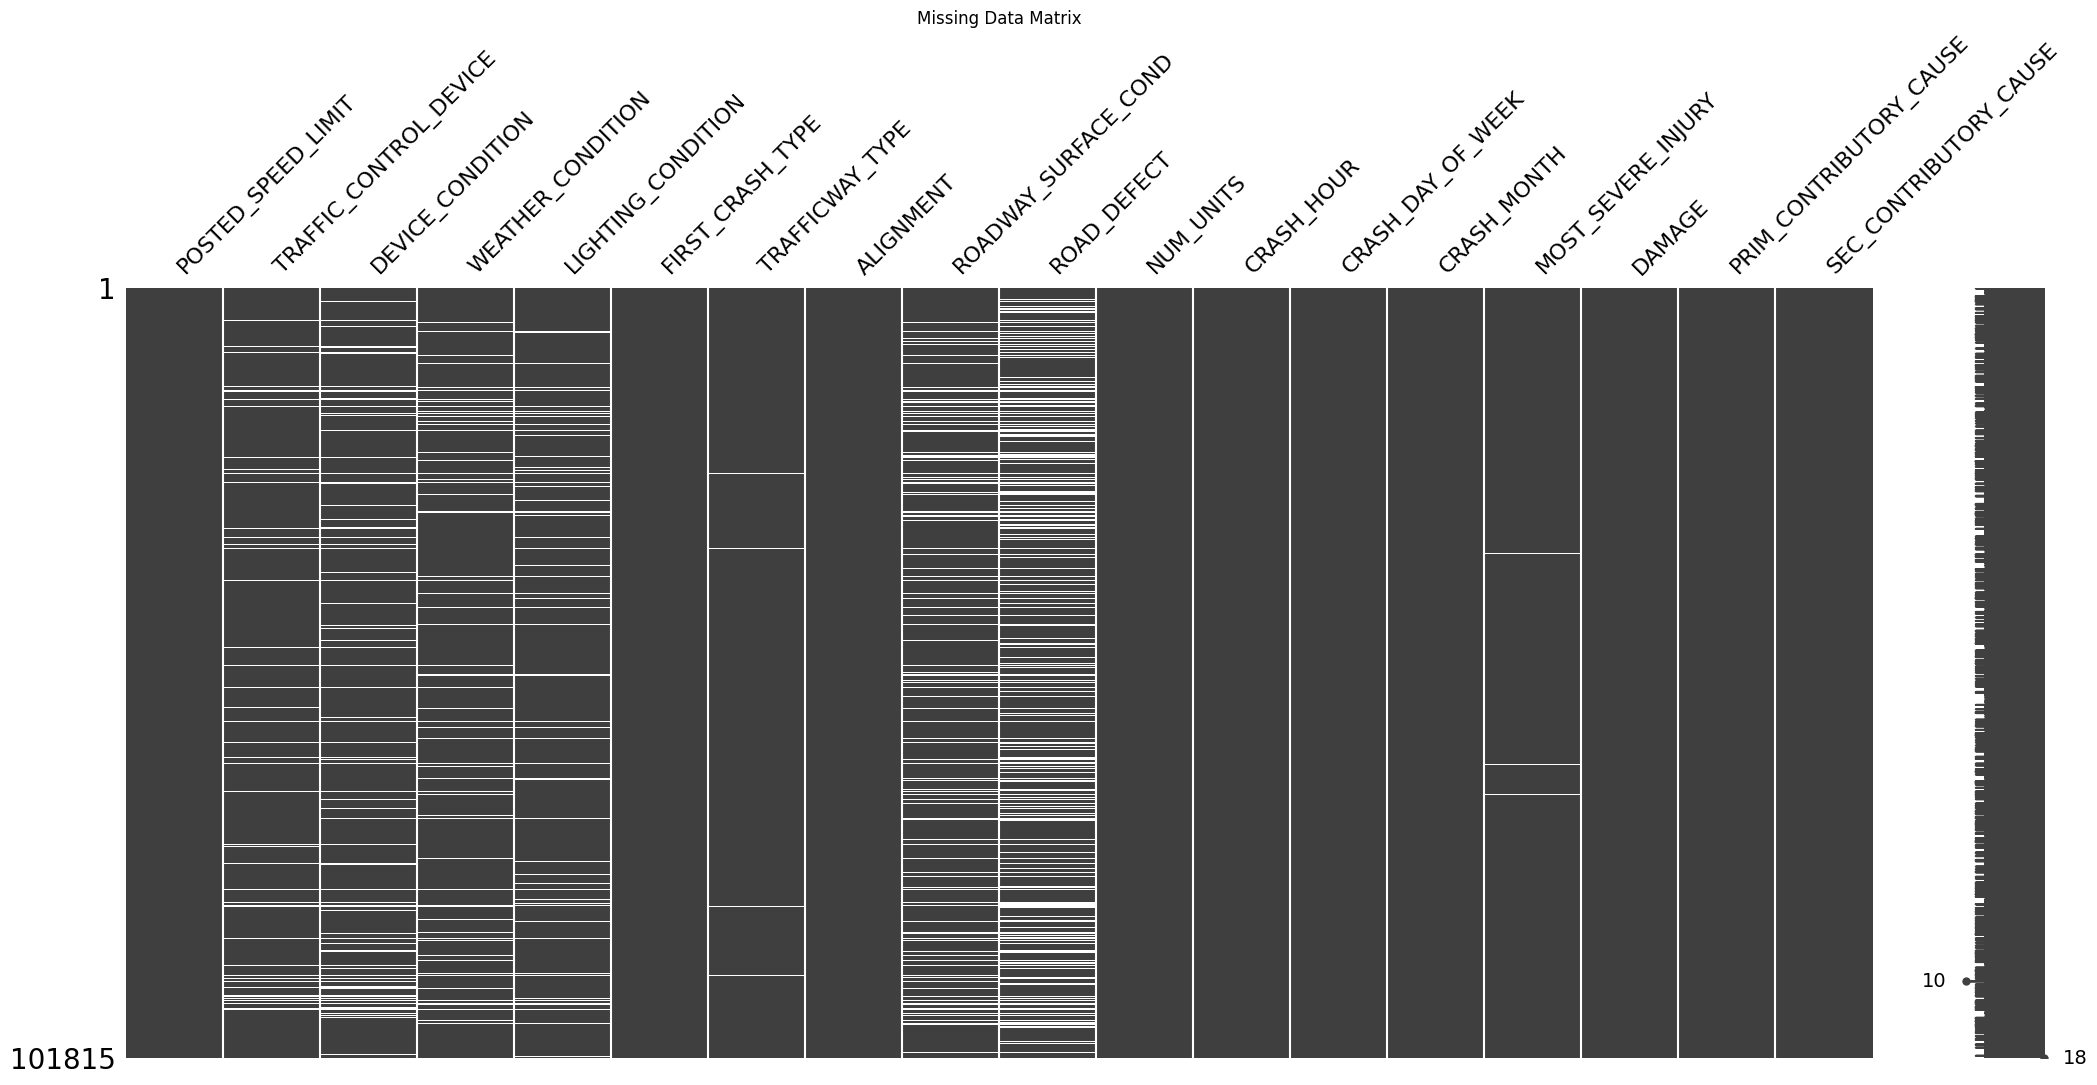

<Figure size 1200x800 with 0 Axes>

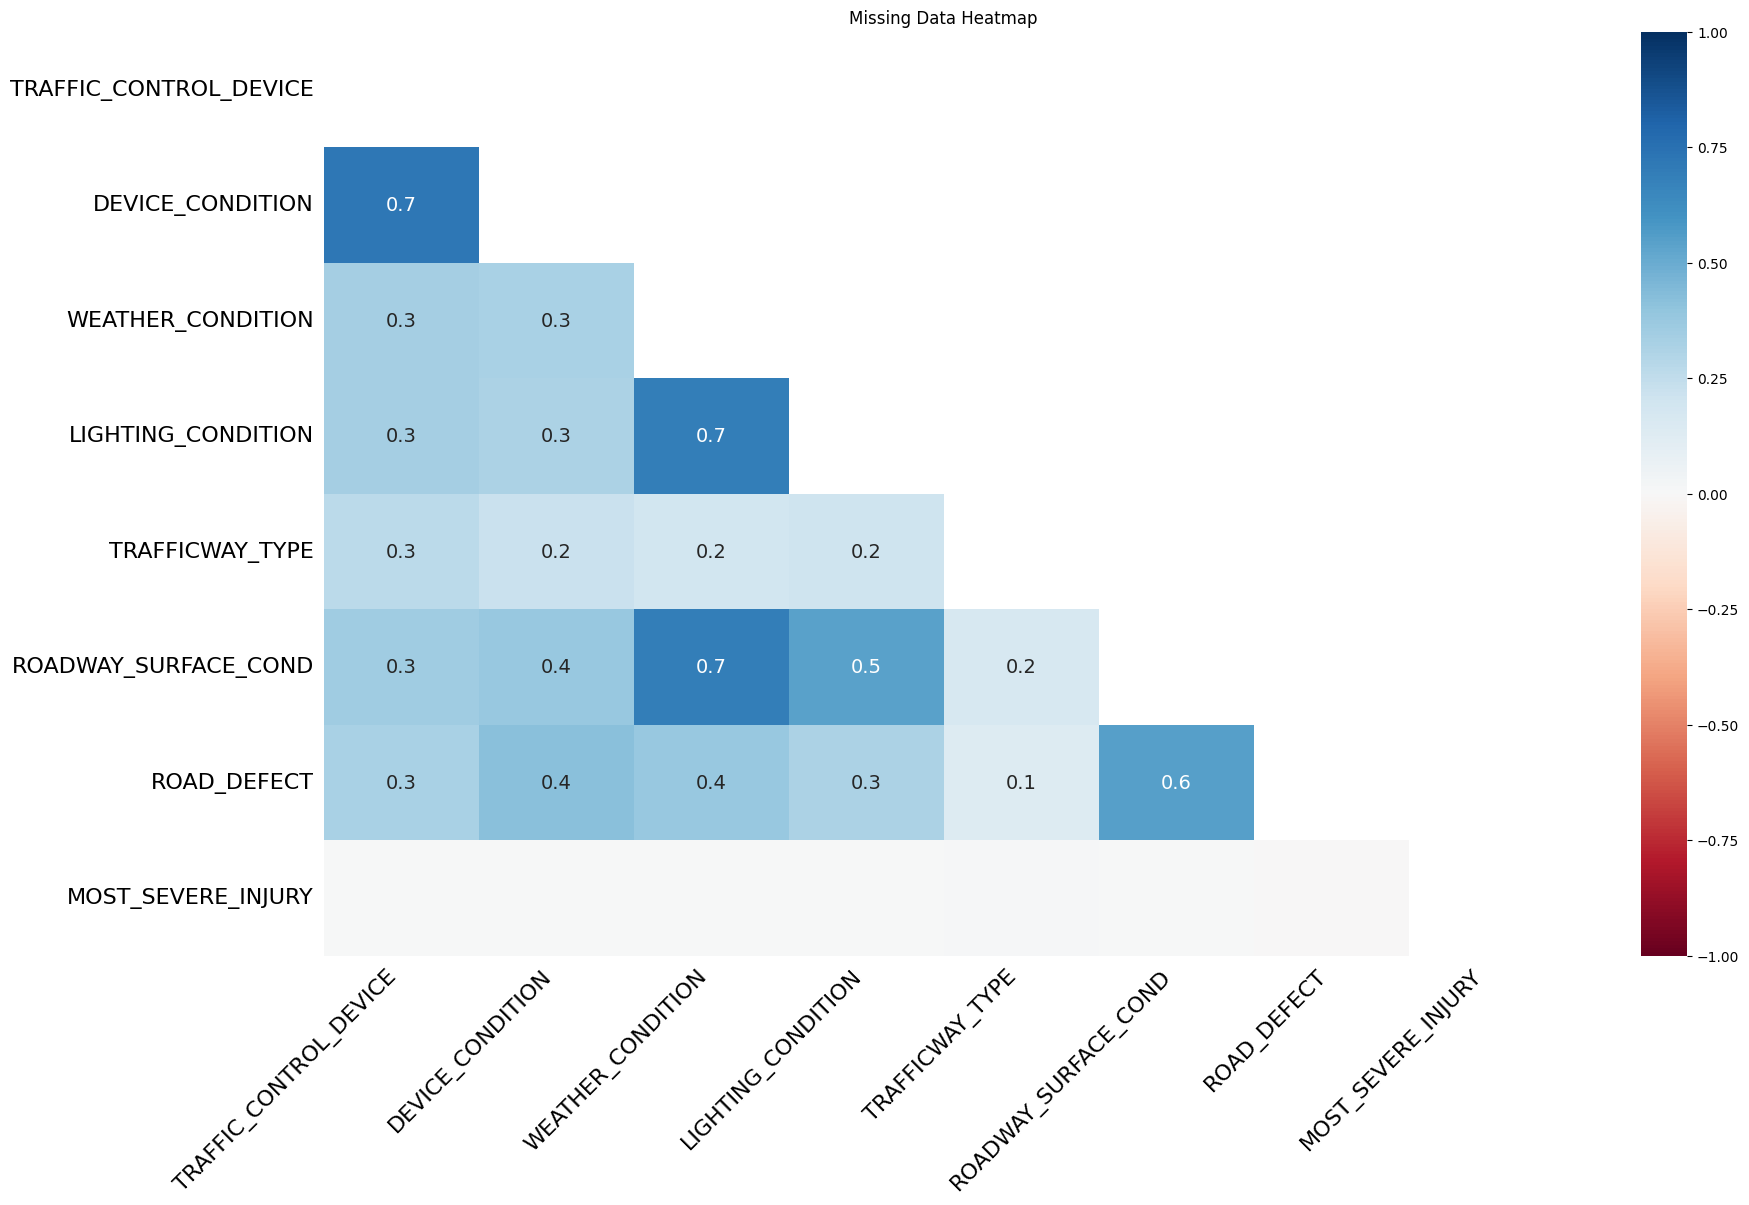

In [ ]:
# missing values analysis with missingno library and matplotlib
import missingno as msno
import matplotlib.pyplot as plt

df_copy = df.copy()

# Replace 'UNKNOWN' with np.NaN for missingno visualization
import numpy as np
cols_with_unknown = ['WEATHER_CONDITION', 'TRAFFICWAY_TYPE', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION']
for col in cols_with_unknown:
    df_copy[col] = df_copy[col].replace('UNKNOWN', np.nan)


# Missingno matrix plot
plt.figure(figsize=(12, 8))
msno.matrix(df_copy)
plt.title('Missing Data Matrix')
plt.show()

# Missingno heatmap plot
plt.figure(figsize=(12, 8))
msno.heatmap(df_copy)
plt.title('Missing Data Heatmap')
plt.show()

**Interpretation of the Heatmap:**

* **`MOST_SEVERE_INJURY` Missingness:** As observed, the row and column corresponding to `MOST_SEVERE_INJURY` show very light colors (close to 0). This indicates a **very low correlation between the missingness of `MOST_SEVERE_INJURY` and the missingness (or "UNKNOWN" values, which we treated as NaN for this visualization) in other variables.** This suggests that the missing values in `MOST_SEVERE_INJURY` are likely occurring somewhat randomly with respect to the other factors we are considering.

* **Correlation Among "UNKNOWN" Categories:**
    * **`DEVICE_CONDITION` and `TRAFFIC_CONTROL_DEVICE` (0.7):** There's a strong positive correlation in their missingness (which originally were "UNKNOWN"). This suggests that when the traffic control device is unknown, its condition is also likely to be unknown, which makes logical sense.
    * **`LIGHTING_CONDITION` and `ROADWAY_SURFACE_COND` (0.7):** There's also a strong positive correlation here. It's plausible that in situations where the lighting condition is unclear (e.g., twilight, poorly lit areas), the road surface condition might also be less clearly reported or more variable.
    * **`WEATHER_CONDITION` with `DEVICE_CONDITION` (0.3) and `LIGHTING_CONDITION` (0.3):** There's a moderate positive correlation, suggesting that in less clear weather conditions, the condition of the device and the lighting might be less consistently reported or harder to ascertain.
    * **`ROADWAY_SURFACE_COND` with `WEATHER_CONDITION` (0.4) and `ROAD_DEFECT` (0.6):** These correlations also make sense. Weather directly impacts road surface conditions, and certain road defects might be more apparent or relevant under specific surface conditions.
    * **`ROAD_DEFECT` and `ROADWAY_SURFACE_COND` (0.6):** This correlation is also logical, as the surface condition can influence the presence or reporting of defects.

* **`MOST_SEVERE_INJURY`:** Since the missingness appears random and the percentage is very low (~0.2%), **dropping the rows with missing values in `MOST_SEVERE_INJURY` is likely the most straightforward and acceptable approach.** We will lose a very small fraction of our data, and there's no strong indication that the missingness is biased by other factors.

* **"UNKNOWN" Categories (Now Represented as NaN):** The correlations we observed suggest that the "UNKNOWN" values are not entirely random and might be related to specific circumstances or reporting inconsistencies. Therefore, **keeping "UNKNOWN" as a separate category (which is what will happen if we don't impute the NaNs we created) seems like the most prudent initial approach.** This allows the model to potentially learn patterns associated with these "unknown" states. We should be mindful of these correlations during modeling and interpretation.

In [152]:
# Drop rows with missing values in MOST_SEVERE_INJURY
df.dropna(subset=['MOST_SEVERE_INJURY'], inplace=True)

# Verify the drop
print("\n--- Missing Values After Dropping: ---\n")
print(df.isnull().sum())


--- Missing Values After Dropping: ---

POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
NUM_UNITS                  0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
MOST_SEVERE_INJURY         0
DAMAGE                     0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
dtype: int64


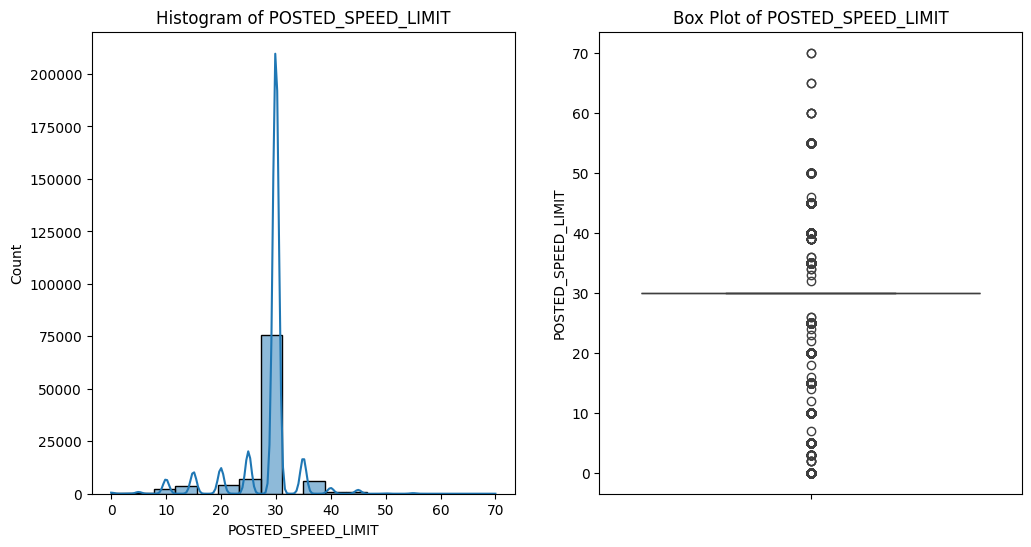


--- Summary Statistics for POSTED_SPEED_LIMIT: ---

count    101582.000000
mean         28.585694
std           5.510538
min           0.000000
25%          30.000000
50%          30.000000
75%          30.000000
max          70.000000
Name: POSTED_SPEED_LIMIT, dtype: float64


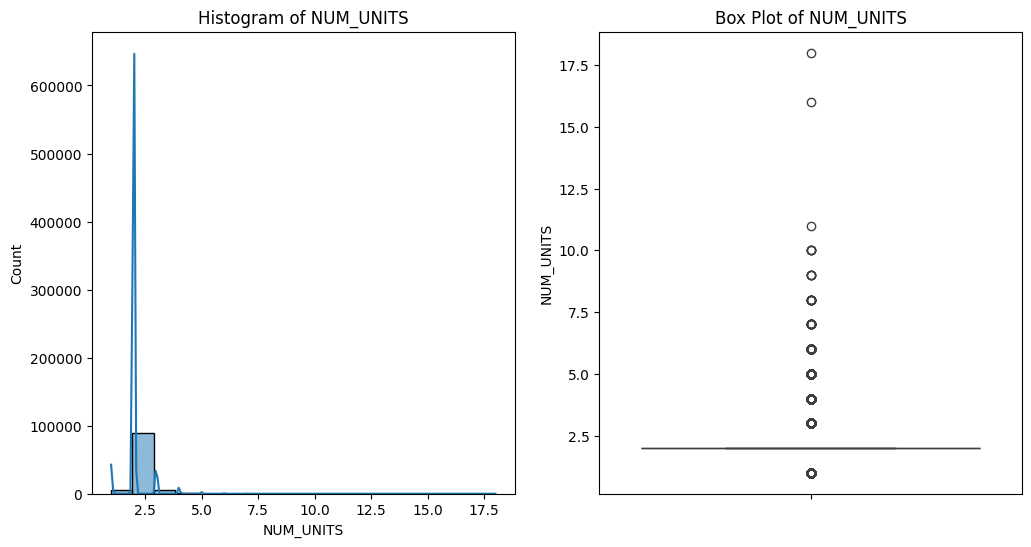


--- Summary Statistics for NUM_UNITS: ---

count    101582.000000
mean          2.038993
std           0.446623
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          18.000000
Name: NUM_UNITS, dtype: float64


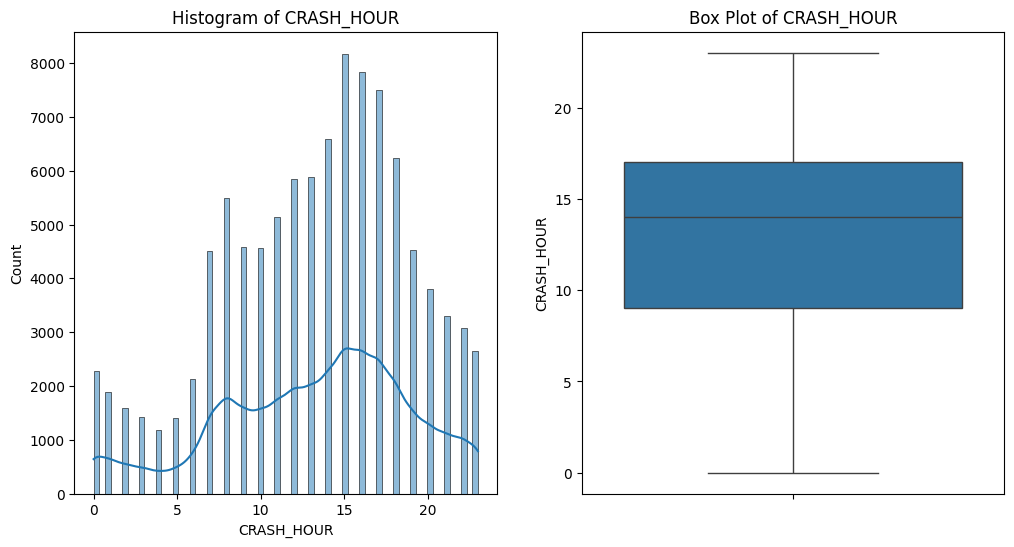


--- Summary Statistics for CRASH_HOUR: ---

count    101582.000000
mean         13.183497
std           5.593011
min           0.000000
25%           9.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: CRASH_HOUR, dtype: float64


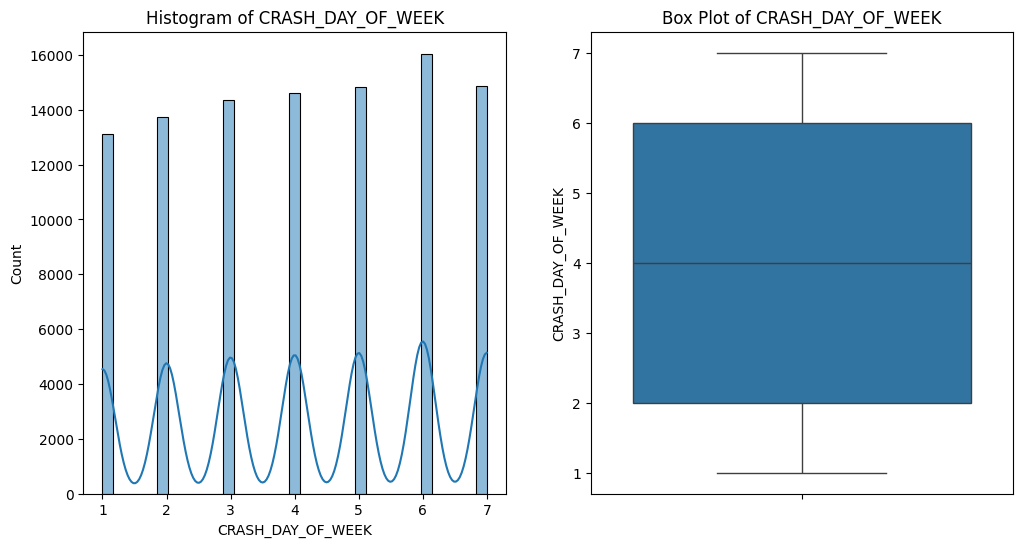


--- Summary Statistics for CRASH_DAY_OF_WEEK: ---

count    101582.000000
mean          4.100707
std           1.982334
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max           7.000000
Name: CRASH_DAY_OF_WEEK, dtype: float64


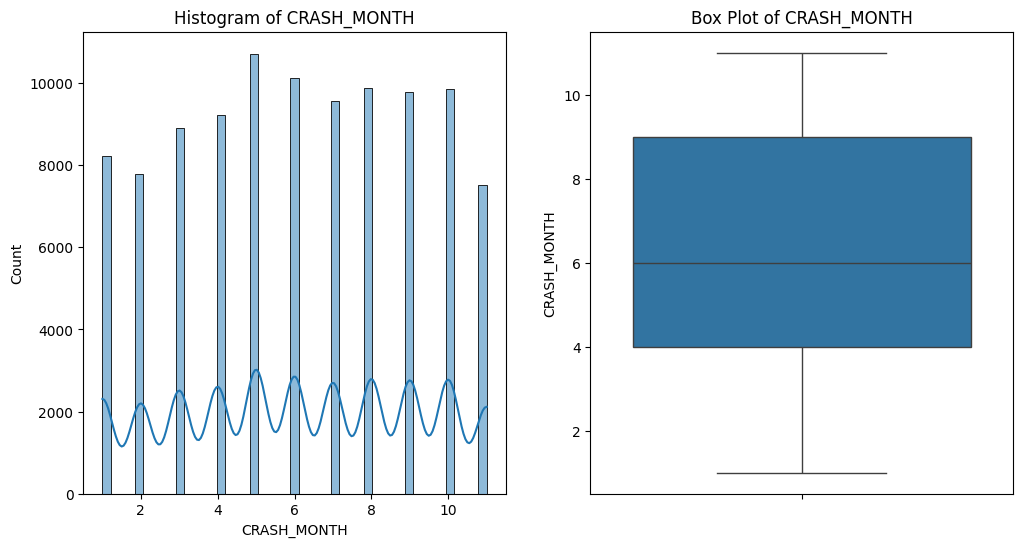


--- Summary Statistics for CRASH_MONTH: ---

count    101582.000000
mean          6.074551
std           3.041890
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          11.000000
Name: CRASH_MONTH, dtype: float64


In [ ]:
import seaborn as sns
# Numerical variables
numerical_cols = ["POSTED_SPEED_LIMIT", "NUM_UNITS", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "CRASH_MONTH"]

# Visualize distributions and box plots for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

    # Print summary statistics
    print(f"\n--- Summary Statistics for {col}: ---\n")
    print(df[col].describe())

In [154]:
print("\n--- Frequency Counts for NUM_UNITS: ---\n")
print(df['NUM_UNITS'].value_counts().sort_index())


--- Frequency Counts for NUM_UNITS: ---

NUM_UNITS
1      5050
2     89601
3      5469
4      1062
5       277
6        82
7        20
8        10
9         4
10        4
11        1
16        1
18        1
Name: count, dtype: int64


* **Handling Outliers and Unknown Categories:**

    * **Outliers**: The primary method for handling outliers was through the grouping of the `NUM_UNITS` column. Values greater than 5 were grouped into a '5+' category, reducing the impact of extreme values.

    * **Unknown Categories**: Several categorical columns contained 'UNKNOWN' or similar values representing missing or unrecorded data. These were retained as separate categories. The rationale is that the 'UNKNOWN' category itself might be predictive. For example, an unknown traffic control device or road defect might correlate with higher injury severity. Removing these rows would have led to a substantial loss of data.

* **Missing Values:** Rows with missing values in the `MOST_SEVERE_INJURY` column were removed to ensure a clean target variable.

**3. Data Cleaning and Preprocessing**

* **\`NUM_UNITS\` Grouping:** The `NUM_UNITS` column (number of vehicles involved in the crash) was grouped to reduce cardinality: values greater than 5 were grouped into a "5+" category.

* **Rare Category Handling:**

    * A 1% threshold was applied to several categorical columns to group rare categories into "OTHER\_[COLUMN_NAME]" to mitigate the impact of infrequent categories on model training.

    * The following columns were processed: `TRAFFIC_CONTROL_DEVICE`, `DEVICE_CONDITION`, `WEATHER_CONDITION`, `LIGHTING_CONDITION`, `FIRST_CRASH_TYPE`, `TRAFFICWAY_TYPE`, `ALIGNMENT`, `ROADWAY_SURFACE_COND`, and `ROAD_DEFECT`.

* **Rationale:** These steps were taken to:

    * Simplify the data.
    * Reduce noise from rare categories.
    * Improve model generalization.


In [155]:
# Group NUM_UNITS
df['NUM_UNITS'] = df['NUM_UNITS'].apply(lambda x: '5+' if x > 5 else str(int(x)))

# Verify the grouping
print("\n--- Frequency Counts for Grouped NUM_UNITS: ---\n")
print(df['NUM_UNITS'].value_counts().sort_index())


--- Frequency Counts for Grouped NUM_UNITS: ---

NUM_UNITS
1      5050
2     89601
3      5469
4      1062
5       277
5+      123
Name: count, dtype: int64


In [156]:
# 1% Threshold
threshold = 0.01
grouped_df = df.copy()

# Function to group rare categories
def group_rare_categories(df, col, threshold=0.01, new_category_name='OTHER'):
    counts = df[col].value_counts(normalize=True)
    rare_categories = counts[counts < threshold].index
    if (len(rare_categories) > 0):
      grouped_df[col] = df[col].apply(lambda x: new_category_name if x in rare_categories else x)
    return grouped_df

# Apply grouping to categorical columns (excluding target variables)
categorical_cols = [
    "TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION",
    "LIGHTING_CONDITION", "FIRST_CRASH_TYPE", "TRAFFICWAY_TYPE",
    "ALIGNMENT", "ROADWAY_SURFACE_COND", "ROAD_DEFECT",
    "PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE", "DAMAGE"
]

for col in categorical_cols:
    grouped_df = group_rare_categories(grouped_df, col, threshold, f'OTHER_{col}')
    print(f"\n--- Value Counts for {col} after grouping: ---\n")
    print(grouped_df[col].value_counts())


--- Value Counts for TRAFFIC_CONTROL_DEVICE after grouping: ---

TRAFFIC_CONTROL_DEVICE
NO CONTROLS                     55173
TRAFFIC SIGNAL                  28315
STOP SIGN/FLASHER               10069
UNKNOWN                          6423
OTHER_TRAFFIC_CONTROL_DEVICE     1602
Name: count, dtype: int64

--- Value Counts for DEVICE_CONDITION after grouping: ---

DEVICE_CONDITION
NO CONTROLS               55867
FUNCTIONING PROPERLY      33804
UNKNOWN                   10613
OTHER_DEVICE_CONDITION     1298
Name: count, dtype: int64

--- Value Counts for WEATHER_CONDITION after grouping: ---

WEATHER_CONDITION
CLEAR                      80046
RAIN                        8217
UNKNOWN                     7794
CLOUDY/OVERCAST             2720
SNOW                        1914
OTHER_WEATHER_CONDITION      891
Name: count, dtype: int64

--- Value Counts for LIGHTING_CONDITION after grouping: ---

LIGHTING_CONDITION
DAYLIGHT                  66045
DARKNESS, LIGHTED ROAD    20680
UNKNOWN         

In [ ]:
# apply semantic grouping to further reduce the number of categories across all columns based on similarity.
for col in categorical_cols:
    df = group_rare_categories(df, col, threshold, f'OTHER_{col}')

In [158]:
# --- Semantic Grouping  ---

df['LIGHTING_CONDITION'] = df['LIGHTING_CONDITION'].replace({
    'DARKNESS': 'LOW LIGHT',
    'DUSK': 'LOW LIGHT',
    'DAWN': 'LOW LIGHT'
})

df['FIRST_CRASH_TYPE'] = df['FIRST_CRASH_TYPE'].replace({
    'OTHER OBJECT': 'OTHER_FIRST_CRASH_TYPE',
})

df['TRAFFICWAY_TYPE'] = df['TRAFFICWAY_TYPE'].replace({
    'OTHER': 'OTHER_TRAFFICWAY_TYPE',
})


# Print Value Counts for all categorical columns after grouping
print("\n--- Value Counts for Categorical Columns After Grouping: ---\n")
for col in categorical_cols:
    print(f"\n--- {col}: ---\n")
    print(df[col].value_counts())


--- Value Counts for Categorical Columns After Grouping: ---


--- TRAFFIC_CONTROL_DEVICE: ---

TRAFFIC_CONTROL_DEVICE
NO CONTROLS                     55173
TRAFFIC SIGNAL                  28315
STOP SIGN/FLASHER               10069
UNKNOWN                          6423
OTHER_TRAFFIC_CONTROL_DEVICE     1602
Name: count, dtype: int64

--- DEVICE_CONDITION: ---

DEVICE_CONDITION
NO CONTROLS               55867
FUNCTIONING PROPERLY      33804
UNKNOWN                   10613
OTHER_DEVICE_CONDITION     1298
Name: count, dtype: int64

--- WEATHER_CONDITION: ---

WEATHER_CONDITION
CLEAR                      80046
RAIN                        8217
UNKNOWN                     7794
CLOUDY/OVERCAST             2720
SNOW                        1914
OTHER_WEATHER_CONDITION      891
Name: count, dtype: int64

--- LIGHTING_CONDITION: ---

LIGHTING_CONDITION
DAYLIGHT                  66045
DARKNESS, LIGHTED ROAD    20680
LOW LIGHT                  8536
UNKNOWN                    6321
Name: count, dtyp

In [ ]:
# save the cleaned data in a different file
df.to_csv("/content/drive/MyDrive/traffic_crashes_2024_cleaned.csv", index=False)

# Feature Engineering

**1. Define the Prediction Task:**

* Let's clearly state what we're trying to predict. In this case, our target variable is `MOST_SEVERE_INJURY`. This is a multi-class classification problem.

**2. Feature Selection:**

* Review the available features and decide which ones to include in the model.
* Consider the relevance of each feature to the target variable.
* Think about potential interactions between features.
* Our current features are:
    * `POSTED_SPEED_LIMIT` (Numerical)
    * `TRAFFIC_CONTROL_DEVICE` (Categorical)
    * `DEVICE_CONDITION` (Categorical)
    * `WEATHER_CONDITION` (Categorical)
    * `LIGHTING_CONDITION` (Categorical)
    * `FIRST_CRASH_TYPE` (Categorical)
    * `TRAFFICWAY_TYPE` (Categorical)
    * `ALIGNMENT` (Categorical)
    * `ROADWAY_SURFACE_COND` (Categorical)
    * `ROAD_DEFECT` (Categorical)
    * `NUM_UNITS` (Categorical - after grouping)
    * `CRASH_HOUR` (Numerical)
    * `CRASH_DAY_OF_WEEK` (Numerical - cyclical)
    * `CRASH_MONTH` (Numerical - cyclical)
    * `DAMAGE` (Categorical)

**3. Feature Engineering:**

* Explore opportunities to create new features that might improve model performance.
* Consider transforming existing features.
* Potential feature engineering ideas:
    * **Time of Day:** Create categories like "Rush Hour," "Daytime," "Nighttime" from `CRASH_HOUR`.
    * **Weekend/Weekday:** Create a binary feature indicating whether the crash occurred on a weekend.
    * **Interaction Features:** Create interaction terms between variables (e.g., `POSTED_SPEED_LIMIT` \* `WEATHER_CONDITION`) if we suspect that the effect of speed limit varies with weather conditions.

**4. Data Preparation for Modeling:**

* Handle categorical variables:
    * **One-Hot Encoding:** Convert categorical variables into numerical format using one-hot encoding.
* Split the data into training and testing sets.

**5. Model Selection:**

* Choose appropriate machine learning models for multi-class classification.
* Consider models that can handle categorical features and potential non-linear relationships.
* Potential models:
    * **XGBoost:** Excellent for handling complex relationships and categorical data.
    * **Random Forest:** Robust and less prone to overfitting(used as base model).
    * **Gradient Boosting Machine (GBM):** Another powerful boosting algorithm.

**6. Model Training and Evaluation:**

* Train the chosen model on the training data.
* Evaluate the model's performance on the testing data using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix).
* Tune hyperparameters to optimize model performance.


**Explanation:**

* **Feature Engineering:**
    * We create `TIME_OF_DAY` based on `CRASH_HOUR`.
    * We create `WEEKEND` based on `CRASH_DAY_OF_WEEK`.
* **Data Preparation:**
    * `pd.get_dummies()` performs one-hot encoding. `drop_first=True` is important to avoid multicollinearity (redundancy in the encoded features).
    * We use sine and cosine transformations to encode the cyclical nature of `CRASH_DAY_OF_WEEK` and `CRASH_MONTH`. This helps the model understand that these are cyclical features (e.g., December is close to January).
    * We drop the original `CRASH_DAY_OF_WEEK` and `CRASH_MONTH` columns after encoding.


In [160]:
# Load the cleaned data
df = pd.read_csv("/content/drive/MyDrive/traffic_crashes_2024_cleaned.csv")

# --- Feature Engineering ---

# Time of Day
def get_time_of_day(hour):
    if 6 <= hour < 10 or 15 <= hour < 19:
        return "Rush Hour"
    elif 10 <= hour < 15:
        return "Daytime"
    elif 19 <= hour < 22:
        return "Evening"
    else:
        return "Nighttime"

df['TIME_OF_DAY'] = df['CRASH_HOUR'].apply(get_time_of_day)

# Weekend/Weekday
df['WEEKEND'] = df['CRASH_DAY_OF_WEEK'].apply(lambda x: 1 if x in [1, 7] else 0)  # 1 for Sunday or Saturday

# --- Data Preparation for Modeling ---

# One-Hot Encode Categorical Variables



# Cyclical Encoding for CRASH_DAY_OF_WEEK and CRASH_MONTH
df['CRASH_DAY_OF_WEEK_sin'] = np.sin(2 * np.pi * df['CRASH_DAY_OF_WEEK'] / 7)
df['CRASH_DAY_OF_WEEK_cos'] = np.cos(2 * np.pi * df['CRASH_DAY_OF_WEEK'] / 7)
df['CRASH_MONTH_sin'] = np.sin(2 * np.pi * df['CRASH_MONTH'] / 12)
df['CRASH_MONTH_cos'] = np.cos(2 * np.pi * df['CRASH_MONTH'] / 12)

df.drop(['CRASH_DAY_OF_WEEK', 'CRASH_MONTH'], axis=1, inplace=True)  # Drop original columns

# Print the first few rows and column info to check
df.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,MOST_SEVERE_INJURY,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,TIME_OF_DAY,WEEKEND,CRASH_DAY_OF_WEEK_sin,CRASH_DAY_OF_WEEK_cos,CRASH_MONTH_sin,CRASH_MONTH_cos
0,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,PARKING LOT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO INDICATION OF INJURY,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,Daytime,0,-0.433884,-0.900969,1.000000,6.123234e-17
1,25,TRAFFIC SIGNAL,UNKNOWN,CLOUDY/OVERCAST,DAYLIGHT,TURNING,FOUR WAY,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,...,NO INDICATION OF INJURY,$500 OR LESS,FOLLOWING TOO CLOSELY,NOT APPLICABLE,Rush Hour,0,0.974928,-0.222521,0.500000,8.660254e-01
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NONINCAPACITATING INJURY,"OVER $1,500",OTHER_PRIM_CONTRIBUTORY_CAUSE,UNABLE TO DETERMINE,Rush Hour,0,0.974928,-0.222521,0.500000,8.660254e-01
3,55,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO INDICATION OF INJURY,"OVER $1,500",NOT APPLICABLE,NOT APPLICABLE,Nighttime,0,0.974928,-0.222521,0.866025,5.000000e-01
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,WET,UNKNOWN,...,NO INDICATION OF INJURY,"OVER $1,500",OTHER_PRIM_CONTRIBUTORY_CAUSE,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,Nighttime,0,0.974928,-0.222521,0.500000,8.660254e-01


# Data visualization

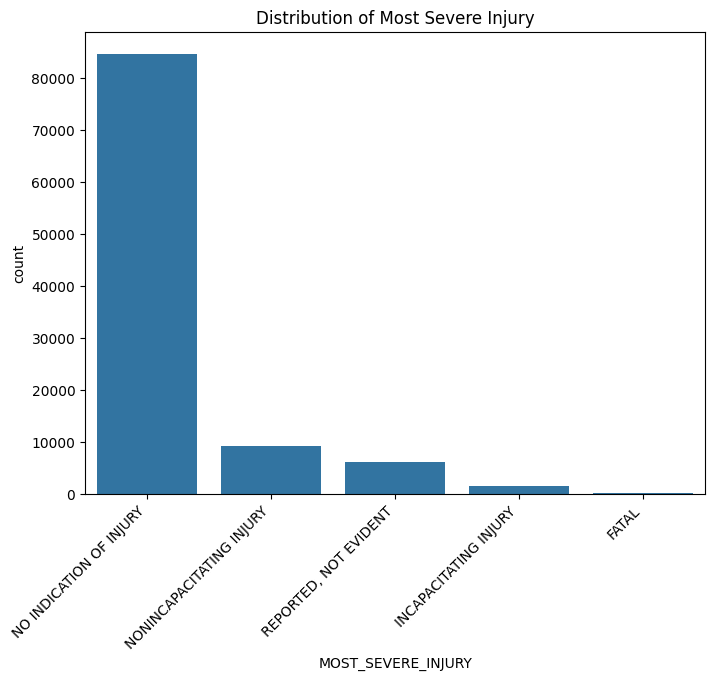

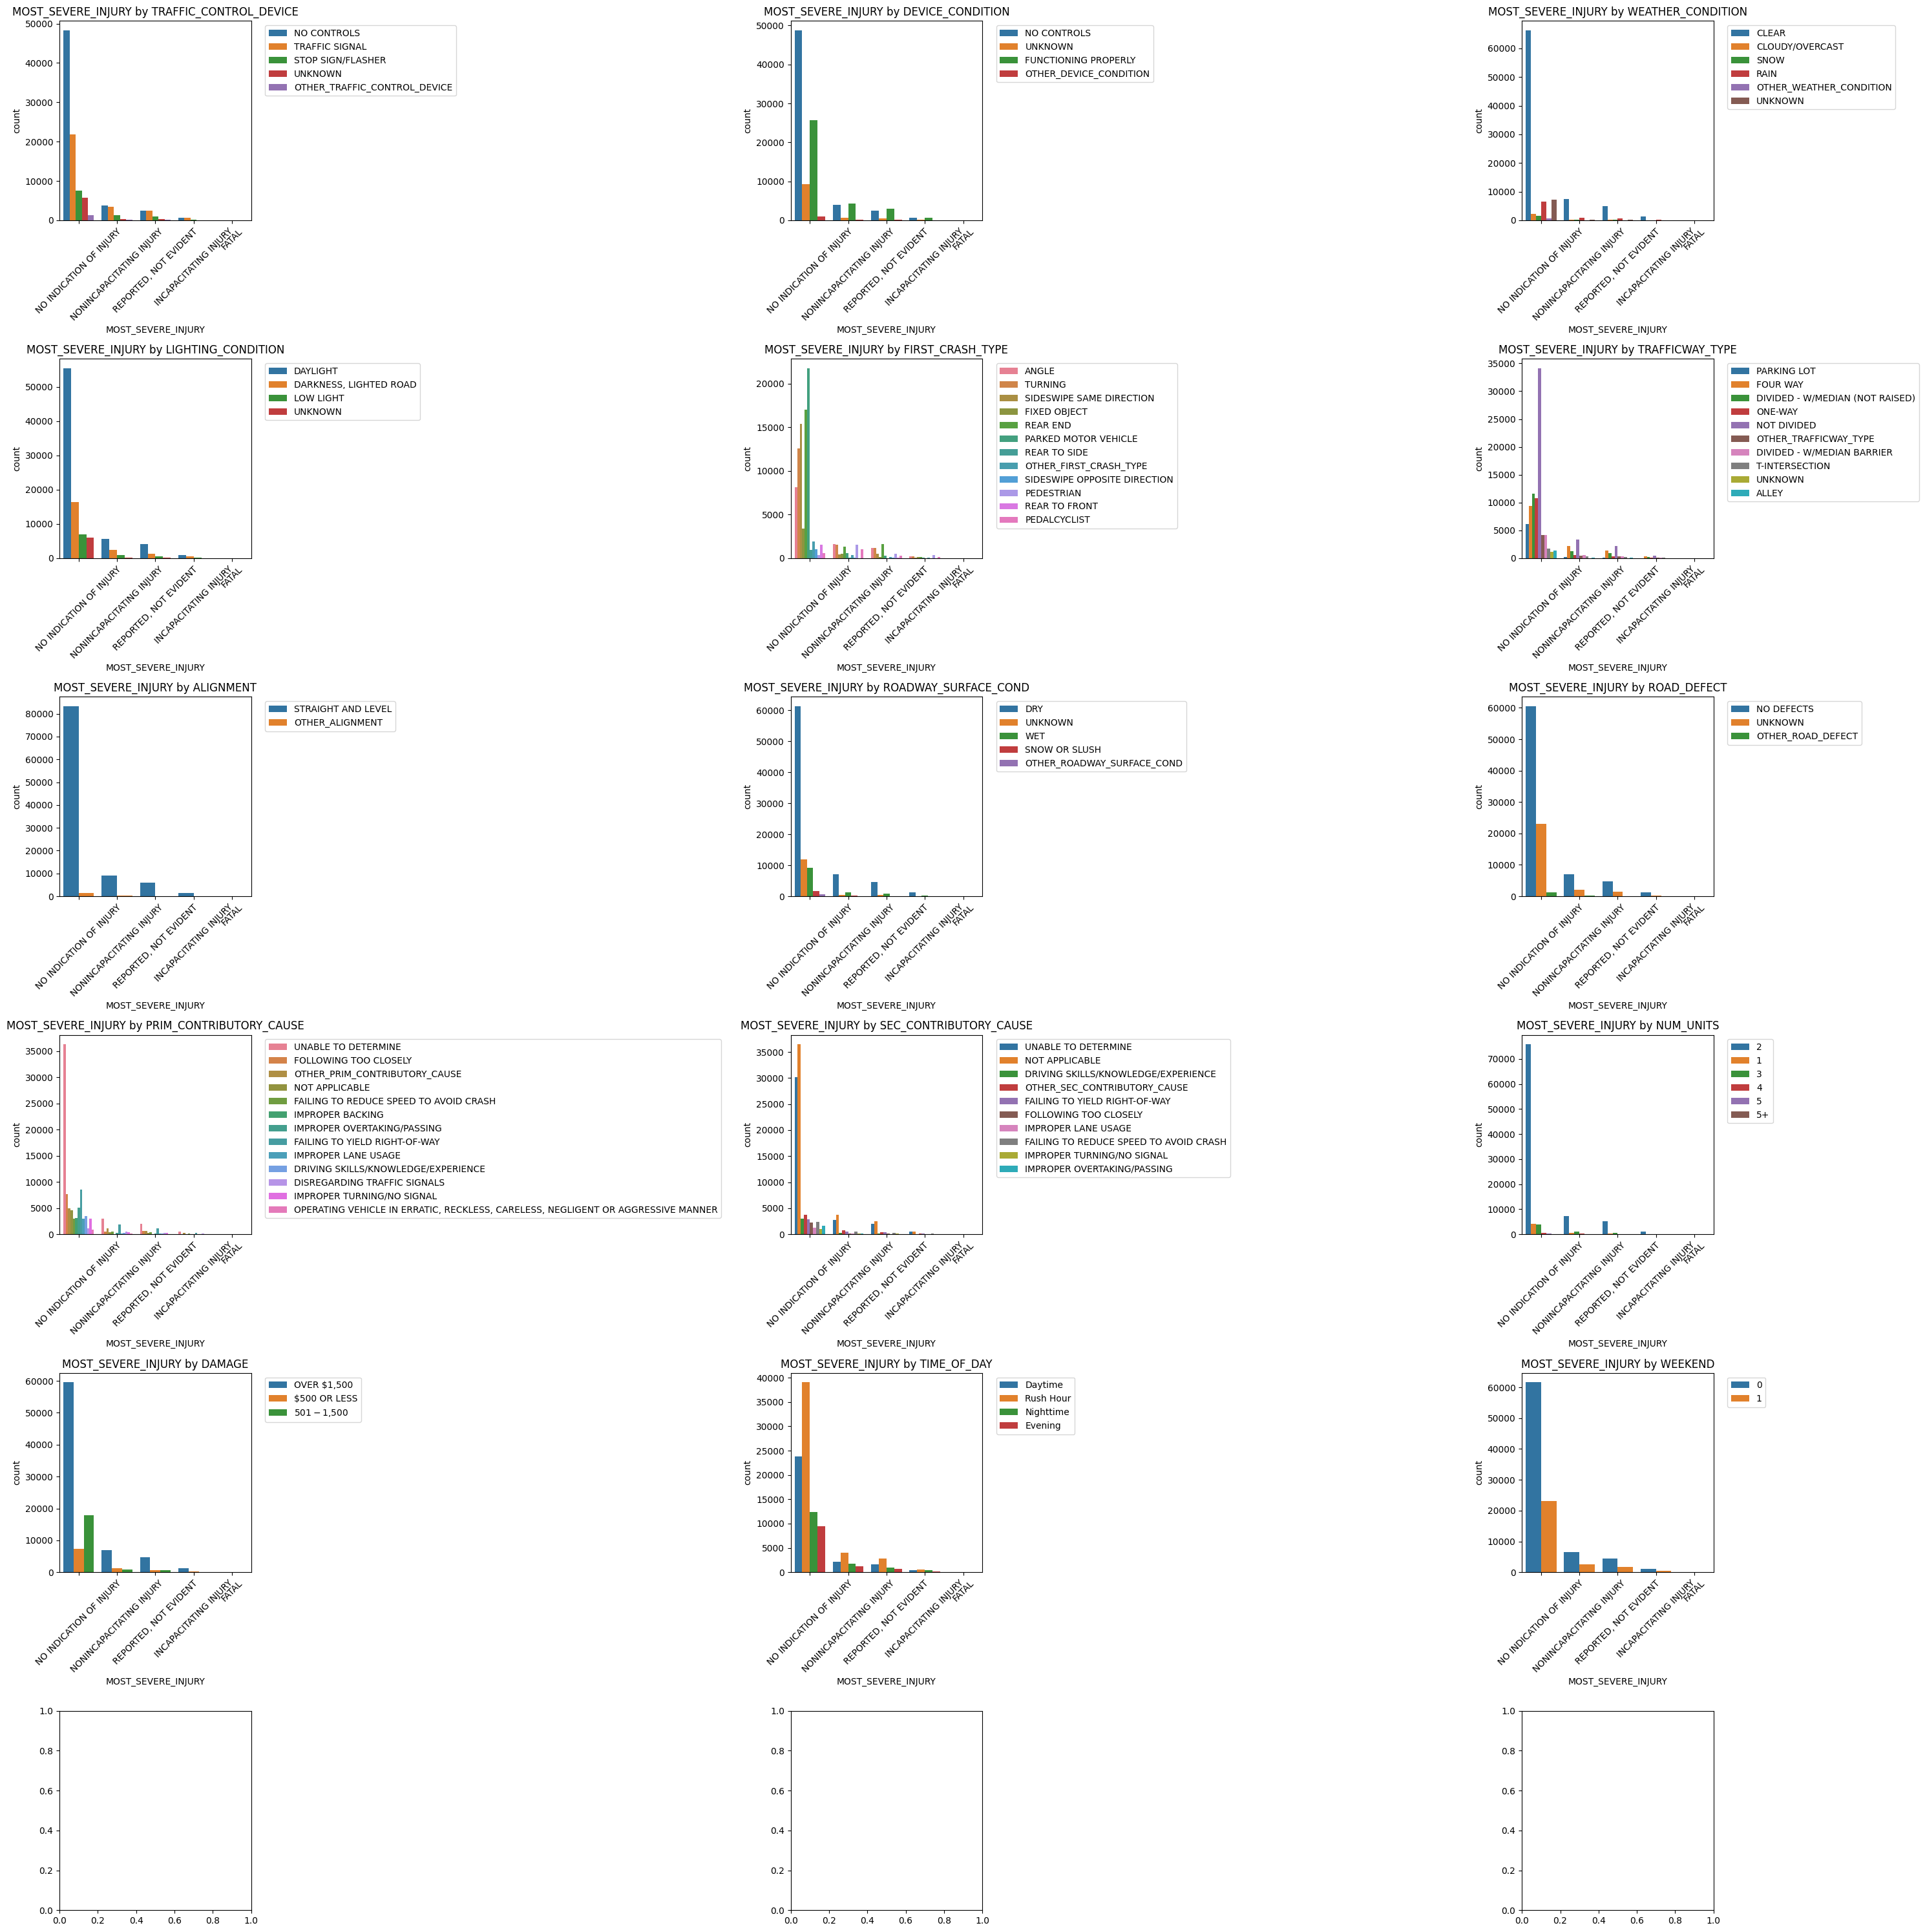

In [ ]:
# --- Data Visualization ---
categorical_cols = [
    "TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION",
    "LIGHTING_CONDITION", "FIRST_CRASH_TYPE", "TRAFFICWAY_TYPE",
    "ALIGNMENT", "ROADWAY_SURFACE_COND", "ROAD_DEFECT",
    "PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE",
    "NUM_UNITS", "DAMAGE", "TIME_OF_DAY", "WEEKEND"
]

# 1. Target Variable Distribution (As before)
plt.figure(figsize=(8, 6))
sns.countplot(x='MOST_SEVERE_INJURY', data=df)
plt.title('Distribution of Most Severe Injury')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2. Categorical Variable Relationships (Combined Visualization)


def plot_categorical_relationships(df, target_col, categorical_cols, rows, cols, figsize_row=5, figsize_col=10):

    fig, axes = plt.subplots(rows, cols, figsize=(figsize_col*cols, figsize_row*rows))  # Adjusted figure size

    for i, col in enumerate(categorical_cols):
        ax_row = i // cols
        ax_col = i % cols
        sns.countplot(x=target_col, hue=col, data=df, ax=axes[ax_row, ax_col])
        axes[ax_row, ax_col].set_title(f'{target_col} by {col}')
        axes[ax_row, ax_col].tick_params(axis='x', rotation=45)
        axes[ax_row, ax_col].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout() # Adjust layout to prevent overlapping
    plt.show()

# Calculate the number of rows and columns for the subplots
num_categorical = len(categorical_cols)
rows = (num_categorical + 3) // 3  # Ensure enough rows to fit all plots (adjust '3' for number of columns)
cols = min(3, num_categorical)      # At most 3 columns (adjust as needed)

plot_categorical_relationships(df, 'MOST_SEVERE_INJURY', categorical_cols, rows, cols)



You're raising a very important point\! Before we proceed further with modeling, it's crucial to consider the characteristics of our target variable, `MOST_SEVERE_INJURY`, and whether we should group its categories.

You're right that there are 4 classes. Let's analyze the distribution from the count plot you provided earlier (I've included it again below for reference):

```
<Figure size 800x600 with 3 Axes>
```

Based on this plot, here's an analysis and some factors to consider for grouping:

**Analysis of `MOST_SEVERE_INJURY` Distribution:**

  * **Class Imbalance:** The plot clearly shows that the classes are imbalanced. "NO INJURY / DRIVE AWAY" is the most frequent, followed by "NONINCAPACITATING INJURY". The other two classes, "INCAPACITATING INJURY" and "FATAL INJURY", are significantly less frequent.
  * **Ordinality:** The target variable has a natural ordinality:
      * NO INJURY / DRIVE AWAY \<br\>
      * REPORTED, NOT EVIDENT/NONINCAPACITATING INJURY \<br\>
      * INCAPACITATING INJURY \<br\>
      * FATAL INJURY

**Reasons for Grouping:**

  * **Class Imbalance:** Imbalanced classes can negatively affect model performance. Models tend to be biased towards the majority class and may have difficulty accurately predicting minority classes. Grouping can help to balance the classes to some extent.
  * **Data Sparsity:** Rare classes have fewer data points, which can lead to unreliable model training and poor generalization. Grouping can increase the number of samples in the combined class.
  * **Model Complexity:** Fewer classes can simplify the modeling task, potentially improving model stability and interpretability.
  * **Practical Considerations:** In some applications, distinguishing between very fine-grained injury severity levels might not be necessary. Grouping can align the prediction task with the practical needs.

**Potential Grouping Strategies:**

Given the ordinality and imbalance, here are a few potential grouping strategies:

1.  **Combine Adjacent Non-Severe Injury Categories:**

      * Group "NO INJURY / DRIVE AWAY" and "REPORTED, NOT EVIDENT/NONINCAPACITATING INJURY" into a "NON-SERIOUS INJURY" category.
      * Keep "INCAPACITATING INJURY" and "FATAL INJURY" as separate categories.
      * This reduces the number of classes to 3 and balances the data somewhat.

2.  **Combine All Injury Categories:**

      * Group "REPORTED, NOT EVIDENT/NONINCAPACITATING INJURY", "INCAPACITATING INJURY", and "FATAL INJURY" into a single "INJURY" category.
      * Keep "NO INJURY / DRIVE AWAY" as a separate category.
      * This results in a binary classification problem (INJURY vs. NO INJURY). This is the most aggressive grouping strategy.

3.  **No Grouping:**

      * Keep all 4 categories as they are.
      * This preserves the most information but requires careful consideration of class imbalance during model training and evaluation.

**Recommendation:**

Start with **Grouping Strategy 1** (Combine Adjacent Non-Severe Injury Categories). This seems like a good compromise, as it addresses the class imbalance to some extent while still preserving some level of detail in injury severity.

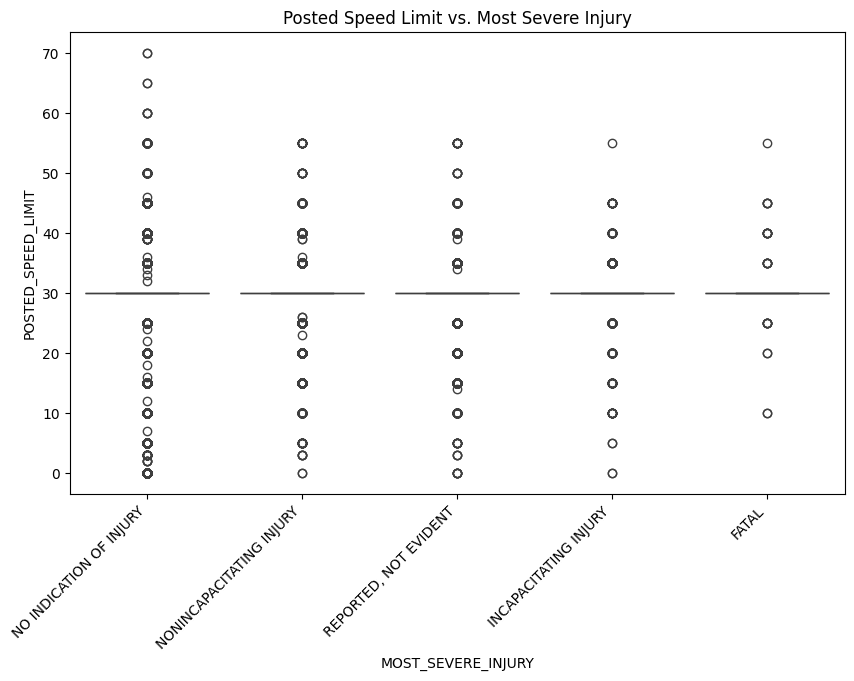

In [ ]:
# 4. Numerical-Categorical Relationships
plt.figure(figsize=(10, 6))
sns.boxplot(x='MOST_SEVERE_INJURY', y='POSTED_SPEED_LIMIT', data=df)
plt.title('Posted Speed Limit vs. Most Severe Injury')
plt.xticks(rotation=45, ha='right')
plt.show()

<Axes: xlabel='count', ylabel='MOST_SEVERE_INJURY'>

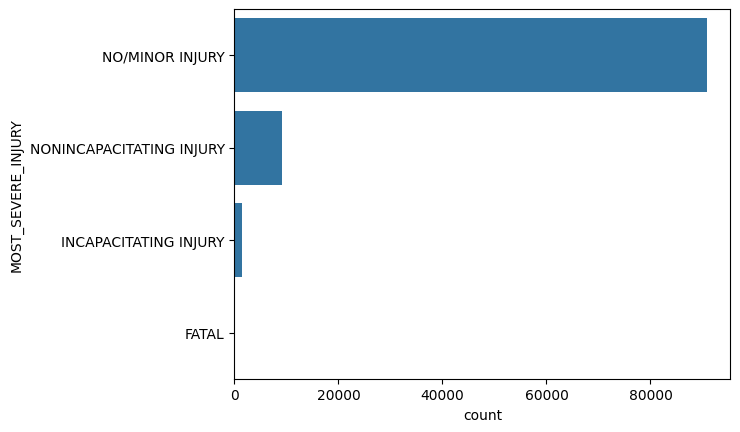

In [161]:
# --- Group the Target Variable ---
df['MOST_SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].replace({
    'NO INDICATION OF INJURY': 'NO/MINOR INJURY',
    'REPORTED, NOT EVIDENT': 'NO/MINOR INJURY'
})
sns.countplot(df, y='MOST_SEVERE_INJURY')

In [163]:
categorical_cols = [
    "TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION",
    "LIGHTING_CONDITION", "FIRST_CRASH_TYPE", "TRAFFICWAY_TYPE",
    "ALIGNMENT", "ROADWAY_SURFACE_COND", "ROAD_DEFECT",
    "PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE",
    "NUM_UNITS", "DAMAGE", "TIME_OF_DAY",
]

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,...,MOST_SEVERE_INJURY,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,TIME_OF_DAY,WEEKEND,CRASH_DAY_OF_WEEK_sin,CRASH_DAY_OF_WEEK_cos,CRASH_MONTH_sin,CRASH_MONTH_cos
0,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,PARKING LOT,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO/MINOR INJURY,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,Daytime,0,-0.433884,-0.900969,1.000000,6.123234e-17
1,25,TRAFFIC SIGNAL,UNKNOWN,CLOUDY/OVERCAST,DAYLIGHT,TURNING,FOUR WAY,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,...,NO/MINOR INJURY,$500 OR LESS,FOLLOWING TOO CLOSELY,NOT APPLICABLE,Rush Hour,0,0.974928,-0.222521,0.500000,8.660254e-01
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NONINCAPACITATING INJURY,"OVER $1,500",OTHER_PRIM_CONTRIBUTORY_CAUSE,UNABLE TO DETERMINE,Rush Hour,0,0.974928,-0.222521,0.500000,8.660254e-01
3,55,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO/MINOR INJURY,"OVER $1,500",NOT APPLICABLE,NOT APPLICABLE,Nighttime,0,0.974928,-0.222521,0.866025,5.000000e-01
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,WET,UNKNOWN,...,NO/MINOR INJURY,"OVER $1,500",OTHER_PRIM_CONTRIBUTORY_CAUSE,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,Nighttime,0,0.974928,-0.222521,0.500000,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101577,40,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,REAR END,FOUR WAY,STRAIGHT AND LEVEL,WET,NO DEFECTS,...,NO/MINOR INJURY,"$501 - $1,500",FAILING TO REDUCE SPEED TO AVOID CRASH,NOT APPLICABLE,Rush Hour,0,0.974928,-0.222521,-0.500000,8.660254e-01
101578,15,NO CONTROLS,NO CONTROLS,CLOUDY/OVERCAST,LOW LIGHT,OTHER_FIRST_CRASH_TYPE,ALLEY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO/MINOR INJURY,"OVER $1,500",OTHER_PRIM_CONTRIBUTORY_CAUSE,UNABLE TO DETERMINE,Rush Hour,0,0.974928,-0.222521,-0.500000,8.660254e-01
101579,15,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,PARKED MOTOR VEHICLE,PARKING LOT,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,...,NO/MINOR INJURY,"OVER $1,500",DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,NOT APPLICABLE,Daytime,0,-0.781831,0.623490,-0.500000,8.660254e-01
101580,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,NO/MINOR INJURY,"$501 - $1,500",NOT APPLICABLE,NOT APPLICABLE,Rush Hour,0,0.974928,-0.222521,-0.500000,8.660254e-01


# Addressing Class Imbalance

**1. Understanding the Challenge**

* Random Forests, like most machine learning algorithms, tend to be biased towards the majority class when the classes are imbalanced. This means they might predict the majority class more often and perform poorly on the minority classes.
* In our case, "NO/MINOR INJURY" will likely dominate predictions if we don't take steps to mitigate this bias.

**2. Techniques to Handle Imbalance in Random Forests (Without Resampling)**

* **Class Weights:**
    * Most Random Forest implementations allow you to assign weights to each class.
    * You can assign higher weights to the minority classes, forcing the model to pay more attention to them.
    * Scikit-learn's `RandomForestClassifier` has the `class_weight` parameter for this purpose. You can set it to "balanced" to automatically assign weights inversely proportional to class frequencies or provide custom weights.
* **Ensemble Methods' Resilience:**
    * Random Forests are ensemble methods, and they are inherently more robust to class imbalance than single decision trees.
    * Bootstrapping (random sampling with replacement) helps create diverse trees, some of which will naturally focus on minority class samples.
    * However, this alone might not be sufficient for severe imbalances.
* **Evaluation Metrics:**
    * Accuracy can be misleading with imbalanced data.
    * Use metrics that are more sensitive to class imbalance:
        * **Precision:** The proportion of correctly predicted positive cases out of all cases predicted as positive.
        * **Recall:** The proportion of correctly predicted positive cases out of all actual positive cases.
        * **F1-score:** The harmonic mean of precision and recall, balancing both.
        * **AUC-ROC:** Area under the Receiver Operating Characteristic curve, useful for binary and multi-class classification.
        * **Confusion Matrix:** Provides a detailed breakdown of correct and incorrect predictions for each class.
* **Probability Threshold Adjustment:**
    * Random Forests provide probability estimates for each class.
    * Instead of using the default 0.5 threshold for classification, you can adjust the threshold to optimize precision or recall for specific classes.
    * This is useful when you have specific requirements for minimizing false positives or false negatives.


# Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Model Building ---
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # drop_first to avoid multicollinearity

# Separate features (X) and target (y)
y = df['MOST_SEVERE_INJURY']
X = df.drop('MOST_SEVERE_INJURY', axis=1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size as needed

In [165]:
# Create a Random Forest Classifier with default parameters
rf_model = RandomForestClassifier(class_weight='balanced', random_state=12)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

# --- Feature Importance ---
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance ---")
print(importance_df)

Accuracy: 0.8962
Classification Report:
                           precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        28
   INCAPACITATING INJURY       0.00      0.00      0.00       326
         NO/MINOR INJURY       0.91      0.99      0.95     18129
NONINCAPACITATING INJURY       0.52      0.15      0.23      1834

                accuracy                           0.90     20317
               macro avg       0.36      0.28      0.29     20317
            weighted avg       0.86      0.90      0.87     20317


--- Feature Importance ---
                                            Feature  Importance
1                                        CRASH_HOUR    0.087030
6                                   CRASH_MONTH_cos    0.058830
5                                   CRASH_MONTH_sin    0.058721
3                             CRASH_DAY_OF_WEEK_sin    0.052447
0                                POSTED_SPEED_LIMIT    0.036565
..              

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**1. Rationale**

* **Anomaly Detection Focus:** Isolation Forest is designed to identify outliers or anomalies in data. The assumption is that severe crashes are rarer and have different characteristics compared to typical crashes, making them potentially detectable as anomalies.


Classification Report (Anomalies vs. Severe Injuries):
               precision    recall  f1-score   support

           0       0.98      0.95      0.97     19963
           1       0.03      0.07      0.04       354

    accuracy                           0.94     20317
   macro avg       0.50      0.51      0.50     20317
weighted avg       0.97      0.94      0.95     20317

Confusion Matrix (Anomalies vs. Severe Injuries):
 [[18992   971]
 [  329    25]]


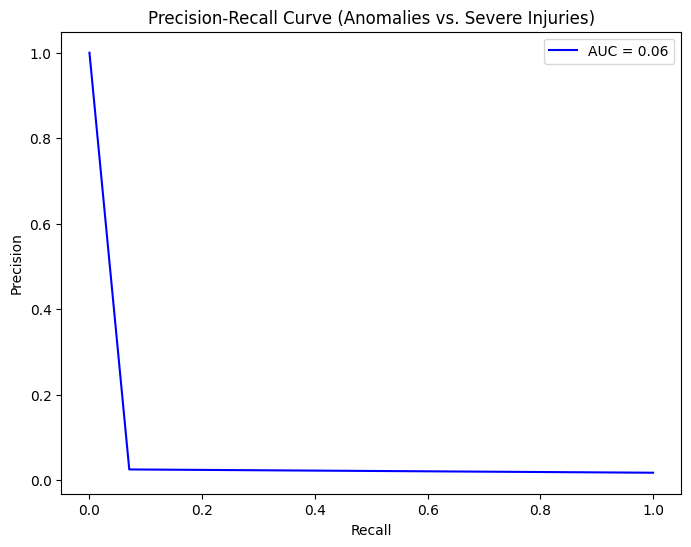

Accuracy: 0.9360


In [169]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve, auc
# Create and train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 'contamination' is an important parameter
iso_forest.fit(X_train)

# Predict anomalies
y_pred_anomaly = iso_forest.predict(X_test)  # -1 for anomaly, 1 for normal

# Convert anomaly predictions to binary labels (for evaluation)
y_anomaly_binary = np.where(y_pred_anomaly == -1, 1, 0)  # 1 for anomaly, 0 for normal

# --- Evaluation ---

# Define severe injury labels
severe_injury_labels = ['FATAL', 'INCAPACITATING INJURY']

# Create binary labels for severe injury (1 if severe, 0 otherwise)
y_test_severe = y_test.isin(severe_injury_labels).astype(int)

# Classification Report (evaluating if anomalies correlate with severe injuries)
print("Classification Report (Anomalies vs. Severe Injuries):\n", classification_report(y_test_severe, y_anomaly_binary))

# Confusion Matrix
print("Confusion Matrix (Anomalies vs. Severe Injuries):\n", confusion_matrix(y_test_severe, y_anomaly_binary))

# Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test_severe, y_anomaly_binary)
auc_score = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Anomalies vs. Severe Injuries)')
plt.legend(loc='upper right')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test_severe, y_anomaly_binary)
print(f"Accuracy: {accuracy:.4f}")

Due to extreme class imbalance, the multi-class task was not feasible in a short time. I built a basic model. With more time, I'd explore advanced imbalance handling (SMOTE, cost-sensitive learning, etc.).